In [1]:
import os

print("Current working directory:")
print(os.getcwd())

print("\nFiles here:")
print(os.listdir())


Current working directory:
/content

Files here:
['.config', 'sample_data']


In [2]:
!mkdir -p data
!wget -r -N -c -np https://physionet.org/files/eegmmidb/1.0.0/S001/ -P data/


--2026-01-17 01:59:23--  https://physionet.org/files/eegmmidb/1.0.0/S001/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘data/physionet.org/files/eegmmidb/1.0.0/S001/index.html’

physionet.org/files     [ <=>                ]   3.48K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2026-01-17 01:59:23 (636 MB/s) - ‘data/physionet.org/files/eegmmidb/1.0.0/S001/index.html’ saved [3565]

Loading robots.txt; please ignore errors.
--2026-01-17 01:59:23--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 22 [text/plain]
Saving to: ‘data/physionet.org/robots.txt’

physionet.org/robot 100%[===================>]      22  --.-KB/s    in 0s      

2026-01-17 01:59:23 (10.5 MB/s) - ‘data/physionet.org/robot

In [3]:
!pip install mne


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 53.7 MB/s eta 0:00:00


In [4]:
import mne

edf_path = "data/physionet.org/files/eegmmidb/1.0.0/S001/S001R03.edf"

raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

print(raw)


<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>


Using matplotlib as 2D backend.


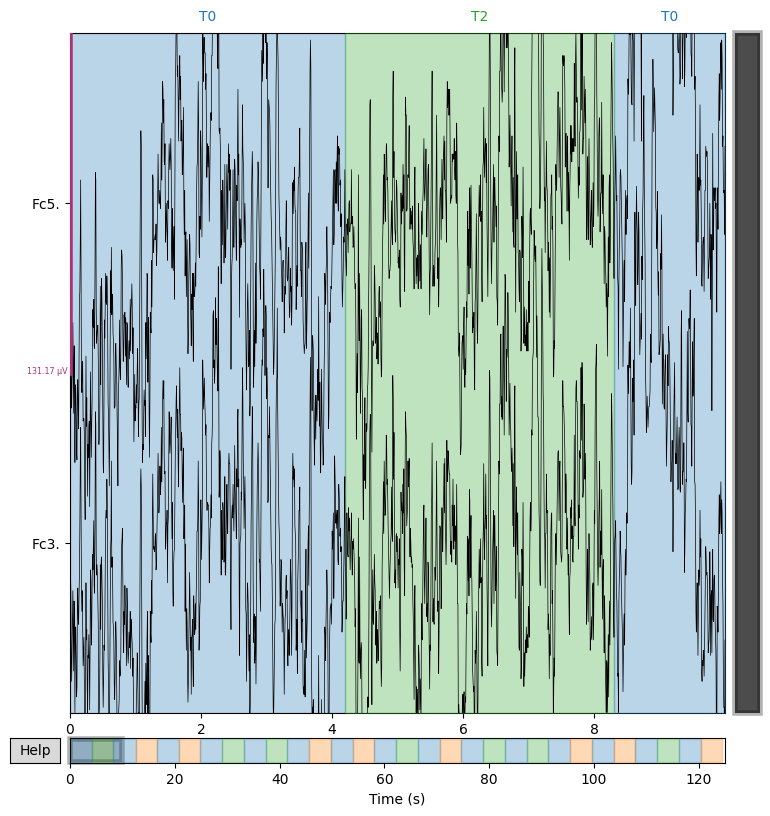

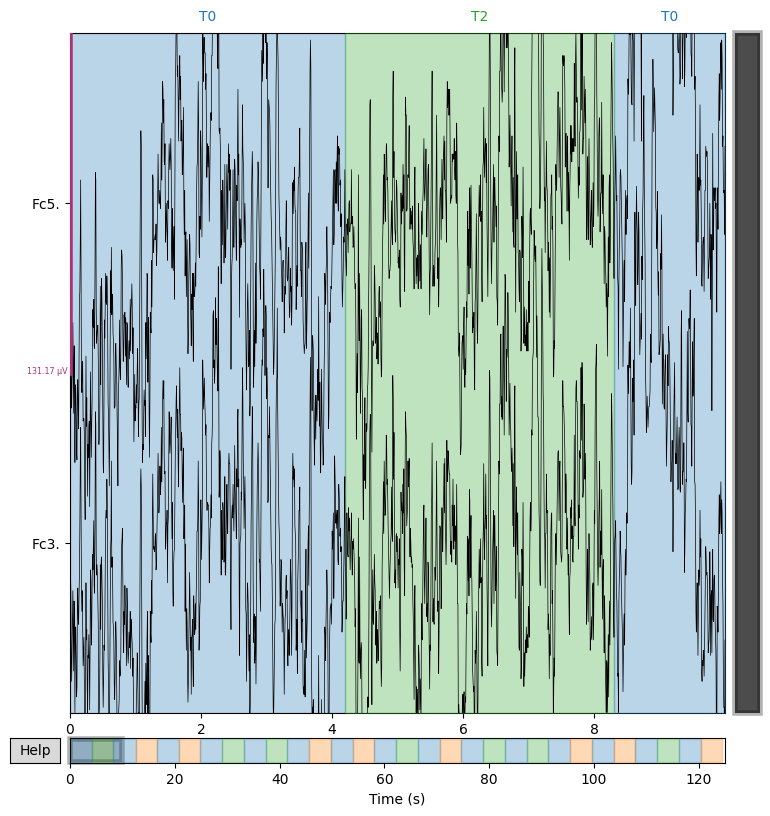

In [5]:
raw.plot(
    picks=[0, 1],
    start=0,
    duration=10,
    scalings="auto"
)


In [6]:
# Extract events from annotations
events, event_id = mne.events_from_annotations(raw)

print("Event IDs:")
print(event_id)

print("\nFirst 10 events:")
print(events[:10])


Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Event IDs:
{np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}

First 10 events:
[[   0    0    1]
 [ 672    0    3]
 [1328    0    1]
 [2000    0    2]
 [2656    0    1]
 [3328    0    2]
 [3984    0    1]
 [4656    0    3]
 [5312    0    1]
 [5984    0    3]]


In [8]:
import numpy as np

sfreq = raw.info["sfreq"]          # should be 160.0
win_sec = 2.0                      # 2-second window
win_samp = int(win_sec * sfreq)

X = []
y = []

data = raw.get_data()              # shape: (channels, samples)

for onset, _, code in events:
    if code in (2, 3):             # 2=T1, 3=T2
        start = onset
        end = onset + win_samp
        if end <= data.shape[1]:
            X.append(data[:, start:end])
            y.append(0 if code == 2 else 1)  # T1->0, T2->1

X = np.stack(X)   # (n_windows, n_channels, win_samp)
y = np.array(y)   # (n_windows,)

print("X shape:", X.shape)
print("y counts (T1=0, T2=1):", np.bincount(y))


X shape: (15, 64, 320)
y counts (T1=0, T2=1): [8 7]


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Flatten each window: (64, 320) -> (64*320,)
X_flat = X.reshape(X.shape[0], -1)

# Split (random, because we only have one subject right now)
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.3, random_state=42, stratify=y
)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred, target_names=["T1", "T2"]))


Accuracy: 0.6
Confusion matrix:
 [[3 0]
 [2 0]]

Report:
               precision    recall  f1-score   support

          T1       0.60      1.00      0.75         3
          T2       0.00      0.00      0.00         2

    accuracy                           0.60         5
   macro avg       0.30      0.50      0.38         5
weighted avg       0.36      0.60      0.45         5



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
!wget -r -N -c -np https://physionet.org/files/eegmmidb/1.0.0/S002/ -P data/
!wget -r -N -c -np https://physionet.org/files/eegmmidb/1.0.0/S003/ -P data/
!wget -r -N -c -np https://physionet.org/files/eegmmidb/1.0.0/S004/ -P data/
!wget -r -N -c -np https://physionet.org/files/eegmmidb/1.0.0/S005/ -P data/
!wget -r -N -c -np https://physionet.org/files/eegmmidb/1.0.0/S006/ -P data/


--2026-01-17 02:07:56--  https://physionet.org/files/eegmmidb/1.0.0/S002/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘data/physionet.org/files/eegmmidb/1.0.0/S002/index.html’

physionet.org/files     [ <=>                ]   3.48K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2026-01-17 02:07:56 (621 MB/s) - ‘data/physionet.org/files/eegmmidb/1.0.0/S002/index.html’ saved [3565]

Loading robots.txt; please ignore errors.
--2026-01-17 02:07:56--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.

--2026-01-17 02:07:56--  https://physionet.org/files/eegmmidb/1.0.0/S002/S002R01.edf
Reusing existing connection to physionet.org:443.
HTTP request se

In [11]:
import os
import glob
import numpy as np
import mne

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

BASE = "data/physionet.org/files/eegmmidb/1.0.0"
SUBJECTS_TRAIN = ["S001","S002","S003","S004","S005"]
SUBJECTS_TEST  = ["S006"]

# We will use imagery runs: R04 (left vs right fist imagery) is a clean starting point.
RUNS = ["R04"]

WIN_SEC = 2.0  # 2-second window after each event
def extract_windows(subject_id):
    X_list, y_list = [], []
    for run in RUNS:
        edf_path = os.path.join(BASE, subject_id, f"{subject_id}{run}.edf")
        if not os.path.exists(edf_path):
            continue

        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
        events, _ = mne.events_from_annotations(raw)

        sfreq = raw.info["sfreq"]
        win_samp = int(WIN_SEC * sfreq)
        data = raw.get_data()  # (channels, samples)

        for onset, _, code in events:
            if code in (2, 3):  # 2=T1, 3=T2
                start = onset
                end = onset + win_samp
                if end <= data.shape[1]:
                    X_list.append(data[:, start:end])
                    y_list.append(0 if code == 2 else 1)  # T1->0, T2->1

    if len(X_list) == 0:
        return None, None

    X = np.stack(X_list)  # (n, ch, t)
    y = np.array(y_list)
    return X, y

def build_dataset(subject_ids):
    X_all, y_all = [], []
    for sid in subject_ids:
        X, y = extract_windows(sid)
        if X is None:
            print(f"{sid}: no windows found")
            continue
        print(f"{sid}: windows={len(y)}, counts={np.bincount(y)}")
        X_all.append(X)
        y_all.append(y)
    X_all = np.concatenate(X_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    return X_all, y_all

# Build train and test sets
X_train, y_train = build_dataset(SUBJECTS_TRAIN)
X_test, y_test   = build_dataset(SUBJECTS_TEST)

# Flatten windows for a simple baseline
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

clf = LogisticRegression(max_iter=3000)
clf.fit(X_train_flat, y_train)

y_pred = clf.predict(X_test_flat)

print("\nCROSS-SUBJECT RESULTS (Train S001-005, Test S006)")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Test counts (T1=0, T2=1):", np.bincount(y_test))


Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
S001: windows=15, counts=[8 7]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
S002: windows=15, counts=[7 8]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
S003: windows=15, counts=[8 7]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
S004: windows=15, counts=[8 7]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
S005: windows=15, counts=[7 8]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
S006: windows=15, counts=[8 7]

CROSS-SUBJECT RESULTS (Train S001-005, Test S006)
Accuracy: 0.5333333333333333
Confusion matrix:
 [[8 0]
 [7 0]]
Test counts (T1=0, T2=1): [8 7]


In [12]:
import os
import glob
import numpy as np
import mne

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

BASE = "data/physionet.org/files/eegmmidb/1.0.0"
SUBJECTS_TRAIN = ["S001","S002","S003","S004","S005"]
SUBJECTS_TEST  = ["S006"]

# We will use imagery runs: R04 (left vs right fist imagery) is a clean starting point.
RUNS = ["R04", "R08", "R12"]

WIN_SEC = 2.0  # 2-second window after each event
def extract_windows(subject_id):
    X_list, y_list = [], []
    for run in RUNS:
        edf_path = os.path.join(BASE, subject_id, f"{subject_id}{run}.edf")
        if not os.path.exists(edf_path):
            continue

        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
        events, _ = mne.events_from_annotations(raw)

        sfreq = raw.info["sfreq"]
        win_samp = int(WIN_SEC * sfreq)
        data = raw.get_data()  # (channels, samples)

        for onset, _, code in events:
            if code in (2, 3):  # 2=T1, 3=T2
                start = onset
                end = onset + win_samp
                if end <= data.shape[1]:
                    X_list.append(data[:, start:end])
                    y_list.append(0 if code == 2 else 1)  # T1->0, T2->1

    if len(X_list) == 0:
        return None, None

    X = np.stack(X_list)  # (n, ch, t)
    y = np.array(y_list)
    return X, y

def build_dataset(subject_ids):
    X_all, y_all = [], []
    for sid in subject_ids:
        X, y = extract_windows(sid)
        if X is None:
            print(f"{sid}: no windows found")
            continue
        print(f"{sid}: windows={len(y)}, counts={np.bincount(y)}")
        X_all.append(X)
        y_all.append(y)
    X_all = np.concatenate(X_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    return X_all, y_all

# Build train and test sets
X_train, y_train = build_dataset(SUBJECTS_TRAIN)
X_test, y_test   = build_dataset(SUBJECTS_TEST)

# Flatten windows for a simple baseline
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

clf = LogisticRegression(max_iter=3000)
clf.fit(X_train_flat, y_train)

y_pred = clf.predict(X_test_flat)

print("\nCROSS-SUBJECT RESULTS (Train S001-005, Test S006)")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Test counts (T1=0, T2=1):", np.bincount(y_test))

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
S001: windows=45, counts=[23 22]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
S002: windows=45, counts=[23 22]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
S003: windows=45, counts=[23 22]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotations descriptions: [np.str_('T0'), np.str_

In [13]:
from sklearn.preprocessing import StandardScaler

# Standardise per channel using training data only
scaler = StandardScaler()

# reshape to (samples*time, channels)
Xtr = X_train.transpose(0, 2, 1).reshape(-1, X_train.shape[1])
Xte = X_test.transpose(0, 2, 1).reshape(-1, X_test.shape[1])

scaler.fit(Xtr)

Xtr_std = scaler.transform(Xtr).reshape(X_train.shape[0], X_train.shape[2], X_train.shape[1]).transpose(0, 2, 1)
Xte_std = scaler.transform(Xte).reshape(X_test.shape[0], X_test.shape[2], X_test.shape[1]).transpose(0, 2, 1)

print("Standardised shapes:", Xtr_std.shape, Xte_std.shape)


Standardised shapes: (225, 64, 320) (45, 64, 320)


In [14]:
import torch
print(torch.__version__)


2.9.0+cpu


In [15]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Use YOUR existing standardised data + labels
Xtr = Xtr_std.astype(np.float32)   # (N, C, T)
Xte = Xte_std.astype(np.float32)
ytr = y_train.astype(np.int64)
yte = y_test.astype(np.int64)

# Convert to torch tensors
Xtr_t = torch.tensor(Xtr).permute(0, 2, 1)  # (N, T, C)
Xte_t = torch.tensor(Xte).permute(0, 2, 1)
ytr_t = torch.tensor(ytr)
yte_t = torch.tensor(yte)

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=32, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xte_t, yte_t), batch_size=64, shuffle=False)

device = torch.device("cpu")
print("Device:", device)

class TinyTransformer(nn.Module):
    def __init__(self, n_channels=64, d_model=64, nhead=4, num_layers=2, num_classes=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(n_channels, d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, num_classes))

    def forward(self, x):  # (B, T, C)
        x = self.input_proj(x)      # (B, T, d_model)
        x = self.encoder(x)         # (B, T, d_model)
        x = x.mean(dim=1)           # (B, d_model)
        return self.head(x)

model = TinyTransformer().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

def eval_acc_and_counts():
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            preds.append(pred)
            trues.append(yb.numpy())
    y_pred = np.concatenate(preds)
    y_true = np.concatenate(trues)
    acc = (y_pred == y_true).mean()
    return acc, y_true, y_pred

for epoch in range(1, 11):  # 10 epochs
    model.train()
    total = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        opt.step()
        total += loss.item() * xb.size(0)

    acc, y_true, y_pred = eval_acc_and_counts()
    print(f"Epoch {epoch:02d} | train_loss={total/len(train_loader.dataset):.4f} | test_acc={acc:.3f}")

acc, y_true, y_pred = eval_acc_and_counts()
print("\nFINAL TEST ACC:", acc)
print("Test counts (T1=0, T2=1):", np.bincount(y_true))
print("Pred counts:", np.bincount(y_pred))


Device: cpu
Epoch 01 | train_loss=1.2107 | test_acc=0.467
Epoch 02 | train_loss=0.7642 | test_acc=0.578
Epoch 03 | train_loss=0.6784 | test_acc=0.711
Epoch 04 | train_loss=0.6798 | test_acc=0.533
Epoch 05 | train_loss=0.6522 | test_acc=0.533
Epoch 06 | train_loss=0.6867 | test_acc=0.733
Epoch 07 | train_loss=0.6191 | test_acc=0.644
Epoch 08 | train_loss=0.5828 | test_acc=0.622
Epoch 09 | train_loss=0.5495 | test_acc=0.711
Epoch 10 | train_loss=0.5304 | test_acc=0.756

FINAL TEST ACC: 0.7555555555555555
Test counts (T1=0, T2=1): [24 21]
Pred counts: [13 32]


In [16]:
import random, numpy as np, torch

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
